In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os

In [2]:
pmt = "KA0220"
wdir = '/data/share/'+pmt
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/Gain/*.bin'.format(wdir))]
fWaves.sort() 
Gains = np.array([float(iF.split('/')[-1].split('V')[0]) for iF in fWaves])
nGains = len(Gains)
print(Gains,fWaves,nGains)

[1549. 1575. 1600. 1625. 1630. 1650. 1675. 1700.] ['/data/share/KA0220/Gain/1549V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1575V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1600V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1625V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1630V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1650V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1675V_200703_100_samples_20000_events', '/data/share/KA0220/Gain/1700V_200703_100_samples_20000_events'] 8


[4.66303667e-03 1.69393939e+02 2.74110677e-01 1.40547382e+00
 1.88571767e+01 9.12669863e-01]
[4.27871229e-03 1.73470618e+02 2.73228260e-01 1.60390158e+00
 1.65770385e+01 9.82462588e-01]
[-1.31417065e-03  1.70100534e+02  2.79400318e-01  1.75995522e+00
  1.57498066e+01  9.95749434e-01]
[-3.48897970e-03  1.66827272e+02  2.85431639e-01  1.96142587e+00
  1.35546466e+01  1.13824085e+00]
[-2.09482378e-03  1.69045633e+02  2.77849200e-01  1.97901824e+00
  1.40688024e+01  1.13868798e+00]
[-6.20719994e-03  1.69075971e+02  2.80683101e-01  2.20637270e+00
  1.29664279e+01  1.23053946e+00]
[1.81177033e-02 1.49798736e+02 3.14941573e-01 2.46367979e+00
 1.17717996e+01 1.34312833e+00]
[1.57825676e-02 1.65014709e+02 2.88194182e-01 2.71660010e+00
 9.89770353e+00 1.58335255e+00]


(array([1549., 1575., 1600., 1625., 1630., 1650., 1675., 1700.]),
 array([0.87721496, 1.00106203, 1.09846163, 1.22420788, 1.23518802,
        1.37708944, 1.53768555, 1.69554369]),
 array([0.02652265, 0.02933011, 0.03033046, 0.03058516, 0.02903115,
        0.02736236, 0.03174834, 0.03978205]))

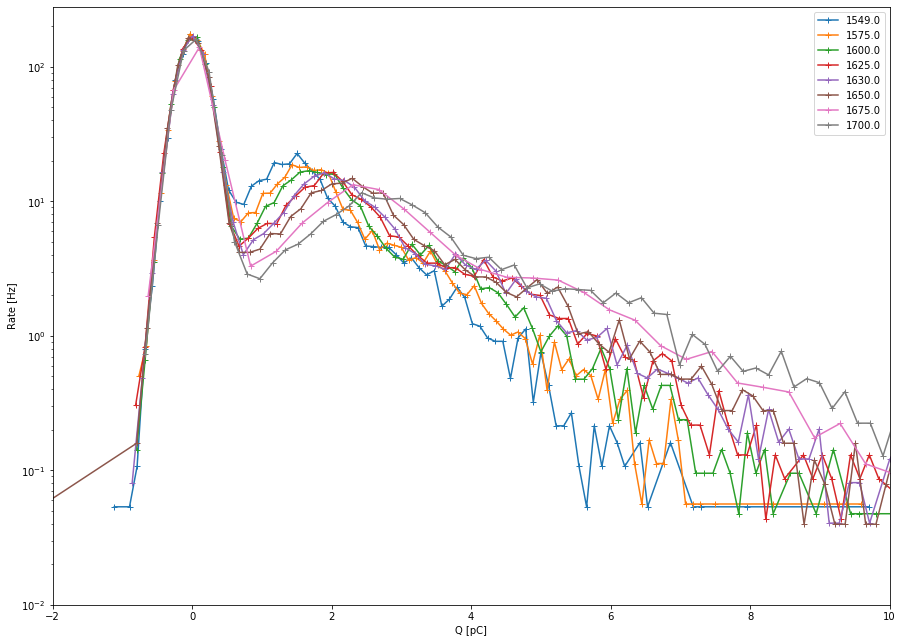

In [3]:
QHists = [tr.extRun(iG,30,3,10,qbins=100,plot=False) for iG in fWaves]
QSPE = np.array([0.]*nGains)
QErr = np.array([0.]*nGains)
for iq in range(nGains):
    #plt.plot(QHists[iq][1],QHists[iq][2],marker='x',label=Gains[iq])
    args = QHists[iq][3]
    lst = 'solid'
    try:
        GFit,GErr = tr.fitQ(QHists[iq],[0,10,1,2,1,1])#,3.2,0.1,1])
        QSPE[iq] = GFit[3]
        print(GFit)
        QErr[iq] = np.sqrt(np.diag(GErr))[3]
    except RuntimeError as e:
        print("Failed to fit {}V Run: {}".format(Gains[iq],e))
        lst = 'dashed'
        QSPE[iq] = np.nan
        QErr[iq] = np.nan
        #plt.plot(QHists[iq][1],QHists[iq][0],marker='x',label=Gains[iq])
    plt.plot(QHists[iq][1][args],QHists[iq][0][args],marker='+',label=Gains[iq],linestyle=lst)
plt.yscale('log')
plt.xlim(-2,10)
plt.legend()
plt.xlabel('Q [pC]')
plt.ylabel('Rate [Hz]')
plt.savefig(pmt+"_GainSPEs.png")

Gains,QSPE/1.6022,QErr

In [4]:
def fit_gain_curve(v, v0, gamma):
    q = ( v / v0 ) ** gamma
    return q
def fit_gain_line(v,v0,gamma):
    q = gamma*v + v0
    return q
qe = 1.6022e-7
from scipy.optimize import curve_fit
fitQ,fitErr = curve_fit(fit_gain_line,Gains,np.log(QSPE/qe),p0=[1,1e3],sigma=QErr/QSPE,absolute_sigma=True)
fitErr = np.sqrt(np.diag(fitErr))
print((fitQ,fitErr,(np.log(1e7)-fitQ[0])/fitQ[1]))
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(Gains,np.log(QSPE/qe))
print(slope, intercept, std_err,(np.log(1e7)-intercept)/slope)

(array([9.22742911e+00, 4.36656279e-03]), array([2.00035805e-01, 1.22220801e-04]), 1578.0527760369048)
0.004350861831960799 9.252737263863292 7.372479048693212e-05 1577.930684137819


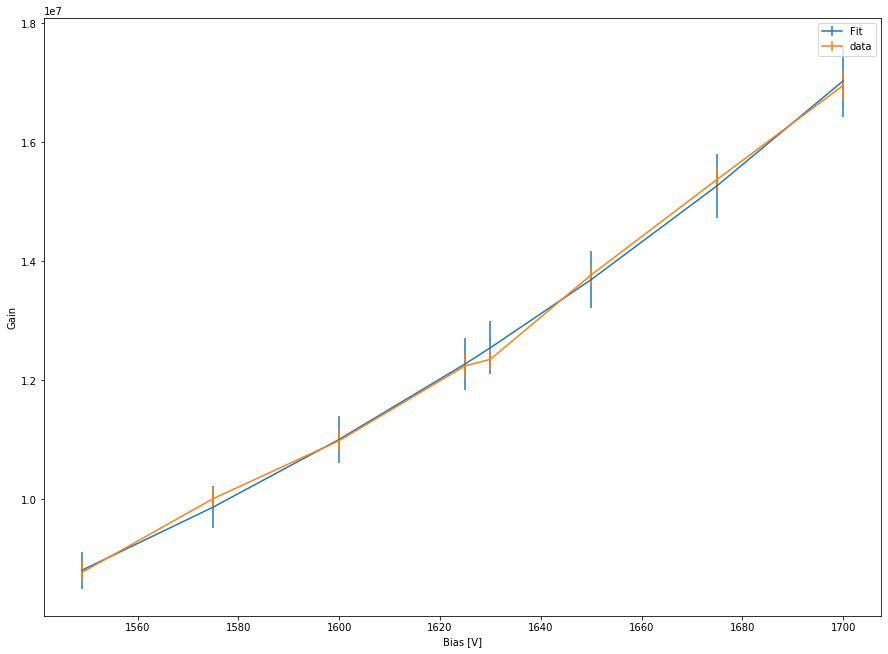

In [5]:
points = np.exp(fitQ[1] * np.array(Gains) + fitQ[0])
pointerr = np.sqrt(np.square(fitErr[1]/fitQ[1])+np.square(fitErr[0]/fitQ[0]))*points
plt.errorbar(Gains,points,yerr=pointerr,label='Fit')
plt.errorbar(Gains,QSPE/qe,label='data',yerr = QErr/qe)
plt.plot()
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Gain')
plt.legend()
plt.savefig(pmt+"_GainCurve.png")


## 